In [1]:
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os
from datetime import datetime
import glob
from tqdm import tqdm

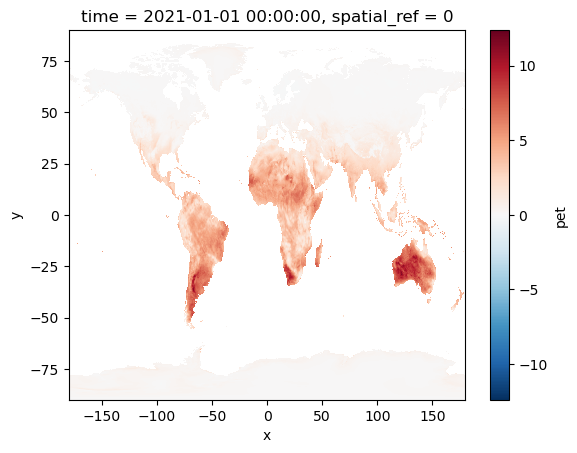

In [4]:
fn = r"/home/waves/projects/smap-drydown/data/PET/2021_daily_pet.nc"
ds = xr.open_dataset(fn, engine="rasterio").sel(time='2021-01-01').rio.write_crs("epsg:4326")
# ds = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture','retrieval_qual_flag','surface_flag'])
ds.pet.plot()

In [5]:
column = pd.read_csv(r"/home/waves/projects/smap-drydown/data/datarods/coord_info_unique_column.csv")
row = pd.read_csv(r"/home/waves/projects/smap-drydown/data/datarods/coord_info_unique_row.csv")

In [6]:
column

,latitude,EASE_column_index
0,83.63197,0
1,81.48033,1
2,79.76896,2
3,78.30298,3
4,76.99911,4
...,...,...
401,-76.99911,401
402,-78.30298,402
403,-79.76896,403
404,-81.48033,404


In [7]:
SMAPL3_file_paths = r"/home/waves/projects/smap-drydown/data/SPL3SMP/SMAP_L3_SM_P_20221231_R18290_001.h5"
_ds_SMAPL3 = xr.open_dataset(SMAPL3_file_paths, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['surface_flag'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':row['longitude'].values, 'y':column['latitude'].values}).rio.write_crs("epsg:4326")
ds_SMAPL3_coord_template

<xarray.Dataset>
Dimensions:                                       (band: 1, y: 406, x: 964)
Coordinates:
  * band                                          (band) int64 1
  * x                                             (x) float64 -179.8 ... 179.8
  * y                                             (y) float64 83.63 ... -83.63
    spatial_ref                                   int64 0
Data variables:
    Soil_Moisture_Retrieval_Data_AM_surface_flag  (band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

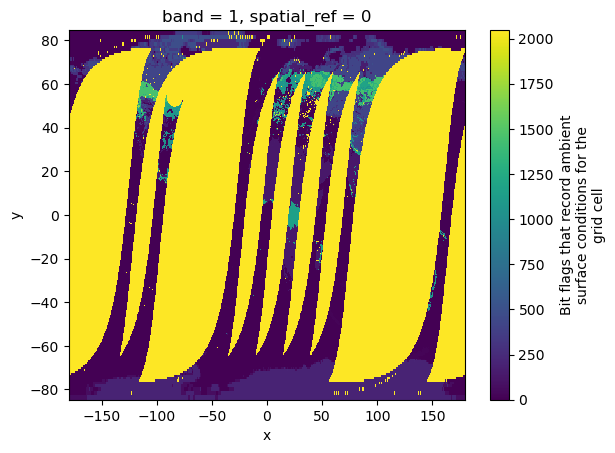

In [8]:
ds_SMAPL3_coord_template.Soil_Moisture_Retrieval_Data_AM_surface_flag.plot()

In [30]:
from rasterio.enums import Resampling
PET_resample = ds.pet.interp_like(ds_SMAPL3_coord_template, method='linear', kwargs={'fill_value': np.nan})

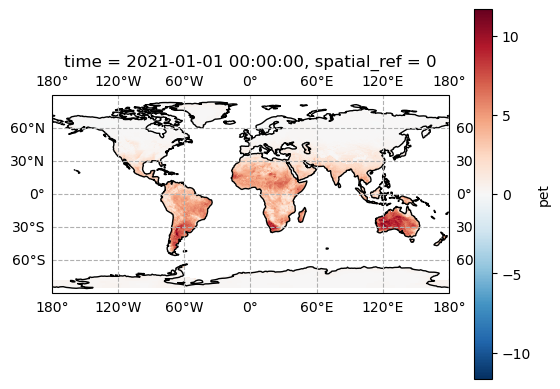

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis with a specified projection (e.g., PlateCarree)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines to the map
ax.add_feature(cfeature.COASTLINE)

# Customize the plot (e.g., add gridlines, set extent)
ax.gridlines(draw_labels=True, linestyle='--')

# Set the map extent (you can customize these coordinates)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

PET_resample.plot(ax=ax)

In [32]:
# Get the coordinates where data is NaN
nan_coords = np.where(np.isnan(PET_resample))

# Convert the coordinates to the labels of the xarray DataArray
# x_coords = PET_resample['x'][nan_coords[0]].values
# y_coords = PET_resample['y'][nan_coords[1]].values
# x_coords, y_coords
# # Zip them together
# coordinates_list = list(zip(x_coords, y_coords))
# print(coordinates_list)
# coordinates_list
nan_coords

(array([0, 0, 0, ..., 0, 0, 0]),
 array([  0,   0,   0, ..., 402, 402, 402]),
 array([  0,   1,   2, ..., 381, 382, 383]))

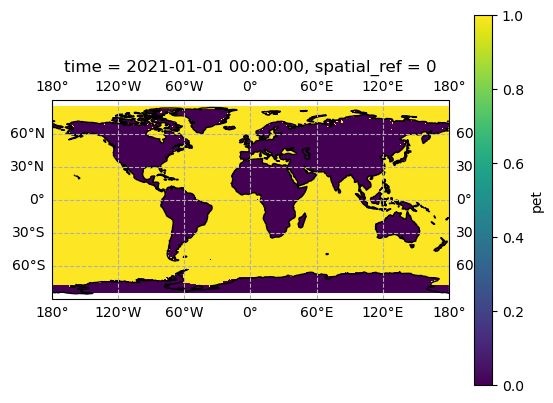

In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis with a specified projection (e.g., PlateCarree)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines to the map
ax.add_feature(cfeature.COASTLINE)

# Customize the plot (e.g., add gridlines, set extent)
ax.gridlines(draw_labels=True, linestyle='--')

# Set the map extent (you can customize these coordinates)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

np.isnan(PET_resample).plot(ax=ax)

In [34]:
nan_coords = np.where(np.isnan(PET_resample))
print(nan_coords[2])

[  0   1   2 ... 381 382 383]


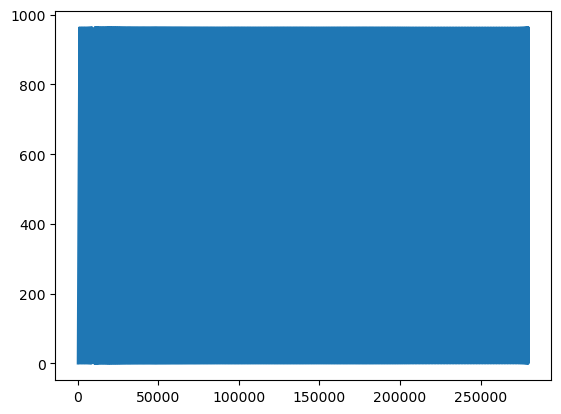

In [35]:
import matplotlib.pyplot as plt
plt.plot(nan_coords[2])

In [36]:
y = nan_coords[1]
x = nan_coords[2]

In [37]:
open_water_data = pd.DataFrame({'EASE_column_index': nan_coords[2], 'EASE_row_index':nan_coords[1]})

In [38]:
open_water_data.to_csv(r"/home/waves/projects/smap-drydown/data/datarods/coord_open_water.csv", index=False)